In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ito_diffusion_1d import *
from ou_fitting import *
from scipy.stats import laplace
plt.style.use('dark_background')

In [2]:
params = {
    'font.size': 14,
    'figure.figsize': (11,18),
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
}
plt.rcParams.update(params)

In [3]:
DAYS_IN_YEAR = 252
T = 8
SCHEME_STEPS = int(DAYS_IN_YEAR*T)

In [4]:
std_dev_weight = 1.0
n_quadrature = 15

## Ornstein-Uhlenbeck (pure diffusion)

$dX_t = -\lambda(\theta_0-X_t)dt + \sigma dW_t$

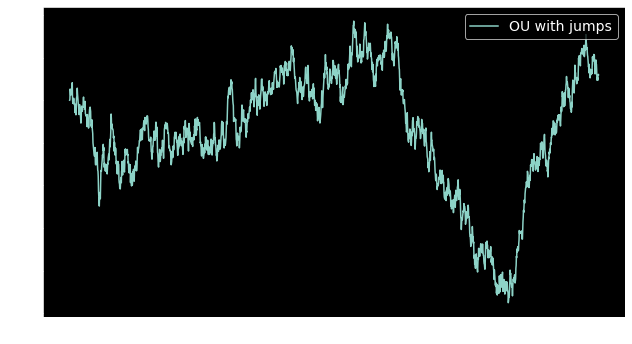

In [5]:
fig, ax = plt.subplots(figsize=(9,5), nrows=1, ncols=1)

mean_reversion = 1.0
long_term = 0.0
vol = 0.4

OU = Vasicek(x0=0.0, T=T, scheme_steps=SCHEME_STEPS, 
             vol=vol, long_term=long_term, mean_reversion=mean_reversion,
            )

df = OU.simulate()

ax.plot(df, label='OU with jumps')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Estimate all parameters at once

Main issue here is identifiability of the model : in stationary mode, the Ornstein-Uhlenbeck distribution depends on the long-term mean and $\frac{\sigma^2}{\lambda}$, thus estimating both volatility and mean-reversion can only be done up to a scaling factor. 

This creates instability in the optimization routine and strongly varying results depending on the starting point of the calibration.

The result of the characteristic function fitting is compared to values obtained by regression (mean-reversion is the slope of the regression of increments to the series of $X_t$, volatility is the standard deviation of the time-scaled increments).

In [6]:
fitter = OU_no_jump_fitter(theta_init_mode='random', 
                           std_dev_weight=std_dev_weight,
                           n_quadrature=n_quadrature,
                          )
fitter.df = df
fitter.regularization = 0.0001

In [7]:
fitter.theta_init

[9.243015624586398, 0.64877695645047, 0.9852693048921363]

In [8]:
fit_info = fitter.fit()
fit_info

/home/sauxpa/Documents/python_scripts/Quant/jump_model/ou_fitting/ou_fitting_no_jump.py:44: RuntimeWarning: overflow encountered in exp
  return np.exp(u*long_term*1j-(u**2)*(vol**2)/(4*mean_reversion))
/home/sauxpa/Documents/python_scripts/Quant/jump_model/ou_fitting/ou_fitting_base.py:239: RuntimeWarning: overflow encountered in double_scalars
  return np.abs(self.char_func_theoretical(u, theta)-self.char_func_empirical(u)) ** 2
/home/sauxpa/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 0.00011060528631466162
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00021256,  0.00025199,  0.00031553])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 364
      nit: 56
   status: 0
  success: True
        x: array([ 0.04951153, -0.14524659,  0.08986159])

In [9]:
print('Ground truth:')
print('mean reversion: {:.2f}'.format(OU.mean_reversion))
print('long term: {:.2f}'.format(OU.long_term))
print('vol: {:.2%}'.format(OU.vol_double))

print('\nFitted:')
print('mean reversion: {:.2f}'.format(fitter.theta[0]))
print('long term: {:.2f}'.format(fitter.theta[1]))
print('vol: {:.0%}'.format(fitter.theta[2]))

print('\nRegression:')
print('mean reversion: {:.2f}'.format(fitter.theta_regression()[0]))
print('long term: {:.2f}'.format(fitter.theta_regression()[1]))
print('vol: {:.0%}'.format(fitter.vol_estimate()))

Ground truth:
mean reversion: 1.00
long term: 0.00
vol: 40.00%

Fitted:
mean reversion: 0.05
long term: -0.15
vol: 9%

Regression:
mean reversion: 0.75
long term: -0.15
vol: 40%


## Estimate volatility separately to avoid identifiability issues

In [10]:
fitter = OU_no_jump_vol_fixed_fitter(theta_init_mode='random',
                                     std_dev_weight=std_dev_weight,
                                     n_quadrature=n_quadrature,
                                    )
fitter.df = df
fitter.regularization = 0.0

In [11]:
fitter.theta_init

[6.808230941247784, 0.6489871018203563]

In [12]:
fit_info = fitter.fit()
fit_info

      fun: 9.280531122135205e-05
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.47434412e-06,  4.04990711e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 93
      nit: 16
   status: 0
  success: True
        x: array([ 0.97368679, -0.14532884])

In [13]:
print('Ground truth:')
print('mean reversion: {:.2f}'.format(OU.mean_reversion))
print('long term: {:.2f}'.format(OU.long_term))
print('vol: {:.2%}'.format(OU.vol_double))

print('\nFitted:')
print('mean reversion: {:.2f}'.format(fitter.theta[0]))
print('long term: {:.2f}'.format(fitter.theta[1]))
print('vol: {:.0%}'.format(fitter.vol_estimate()))

print('\nRegression:')
print('mean reversion: {:.2f}'.format(fitter.theta_regression()[0]))
print('long term: {:.2f}'.format(fitter.theta_regression()[1]))
print('vol: {:.0%}'.format(fitter.vol_estimate()))

Ground truth:
mean reversion: 1.00
long term: 0.00
vol: 40.00%

Fitted:
mean reversion: 0.97
long term: -0.15
vol: 40%

Regression:
mean reversion: 0.75
long term: -0.15
vol: 40%
